# PSO fit
18 November 2019

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# (pip install pyswarms pyyaml)
import pyswarms as ps
from pyswarms.utils.plotters import plot_cost_history, plot_contour, plot_surface

from multiprocessing import Pool

from helpers import DefaultImage

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
import lenstronomy.Util.param_util as param_util
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.psf import PSF
import lenstronomy.Util.image_util as image_util
from lenstronomy.Workflow.fitting_sequence import FittingSequence

# Generate original image

In [3]:
N = 2
zs = 1.0
zl = .2
zd = .2 # interloper redshift
image_obj = DefaultImage(N, zl=zl, zd=zd, zs=zs)
image = image_obj.image

# Define fit model

In [4]:
# assume 1 interloper/subhalo for now
lens_model_fit_list = ['SPEP']+['NFW']*N if zl < zd else ['NFW']*N+['SPEP']
lens_model_fit = LensModel(lens_model_list=lens_model_fit_list,
                         z_source=zs, multi_plane=False)

image_model_fit = ImageModel(data_class=image_obj.pixel_grid,
                             psf_class=image_obj.psf,
                             lens_model_class=lens_model_fit,
                             source_model_class=image_obj.light_model_source,
                             lens_light_model_class=image_obj.light_model_lens,
                             kwargs_numerics=image_obj.kwargs_numerics)

def gen_image_fit(kwargs_lens_model):
    image = image_model_fit.image(kwargs_lens=kwargs_lens_model,
                                  kwargs_source=image_obj.kwargs_light_source,
                                  kwargs_lens_light=image_obj.kwargs_light_lens)
    # (could also add kwargs_ps)
    return image

def error(image1, image2):
    assert(image1.shape == image2.shape)
    
    diffsq = (image1 - image2).flatten()**2
    
#     skipidx = 20100 # todo maybe undo this
#     return np.sum(diffsq[:skipidx]) + np.sum(diffsq[skipidx+1:])
    return np.sum(diffsq)

def args_to_img(args):
    assert(len(args) == 2*N+2)
    rsang = args[0]
    alphars = args[1]
    xs = args[2:N+2]
    ys = args[N+2:]
#     rsang = image_obj.rsang
#     alphars = image_obj.alphars
#     xs = [args[0]]
#     ys = [args[1]]
    
    
    my_spep = image_obj.kwargs_spep
    my_nfw_list = []
    for i in range(N):
        my_nfw = {'Rs': rsang, 'alpha_Rs': alphars,
                  'center_x': xs[i], 'center_y': ys[i]}
        my_nfw_list.append(my_nfw)

    image_macro = gen_image_fit([my_spep]+my_nfw_list if zl < zd else my_nfw_list+[my_spep])
    return image_macro

def in_limits(args):
    xs = args[2:N+2]
    ys = args[N+2:]
    pos_lim = 300 #np.inf
    
    if args[0] < 0 or args[1] < 0: return False
    elif np.any(abs(xs) > pos_lim) or np.any(abs(ys) > pos_lim): return False
    elif args[0] > 2: return False # TODO: figure out what reasonable limits are
    elif args[1] > .01: return False # TODO: ditto
    else: return True

def cost_one(args):
    err = error(image, args_to_img(args))
    return err
#     if not in_limits(args):
#         return -np.inf
#     else:
#         err = error(image, args_to_img(args))
#     return -err #note: can make walkers go closer to the optimum by multiplying the err function

In [5]:
def cost_func(args_2d):
    cost_one_list = []
    for args in args_2d:
        cost_one_list.append(cost_one(args))
    return np.array(cost_one_list)

In [6]:
keys = ['rsang', 'alphars'] + ['center_x']*N + ['center_y']*N
#keys = ['center_x']*N + ['center_y']*N

ndim = len(keys)

In [25]:
## Bounds ##

max_bound = [.5,3e-4] + [30]*(2*N) # cost 0.000193 with {'c1': 0.25, 'c2': 0.6, 'w':0.9}. 32 particles
min_bound = [0,0] + [-30]*(2*N)
bounds = (np.array(min_bound),np.array(max_bound))

In [26]:
# Set-up hyperparameters
# options = {'c1': 0.5, 'c2': 0.3, 'w':0.9} # default values
options = {'c1': 0.25, 'c2': 0.6, 'w':0.9}
# I believe the hyperparameters are as follows:
# w: constant inertia weight
# c1: cognitive parameter
# c2: social parameter
# (see this site: https://nathanrooy.github.io/posts/2016-08-17/simple-particle-swarm-optimization-with-python/ )

# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=32, dimensions=ndim,
                                    options=options, bounds=bounds)

In [27]:
# Perform optimization
cost, pos = optimizer.optimize(cost_func, iters=200) # small improvements still possible for a lot more iterations

2019-11-20 11:32:48,664 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c2': 0.6, 'w': 0.9, 'c1': 0.25}
pyswarms.single.global_best: 100%|██████████|200/200, best_cost=0.000146
2019-11-20 11:34:44,858 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0001456601310588069, best pos: [ 3.08072090e-01  7.53325474e-05  1.52803572e+01 -1.01123271e+01
  1.29814119e+00  1.69333363e+01]


In [28]:
cost, pos

(0.0001456601310588069,
 array([ 3.08072090e-01,  7.53325474e-05,  1.52803572e+01, -1.01123271e+01,
         1.29814119e+00,  1.69333363e+01]))

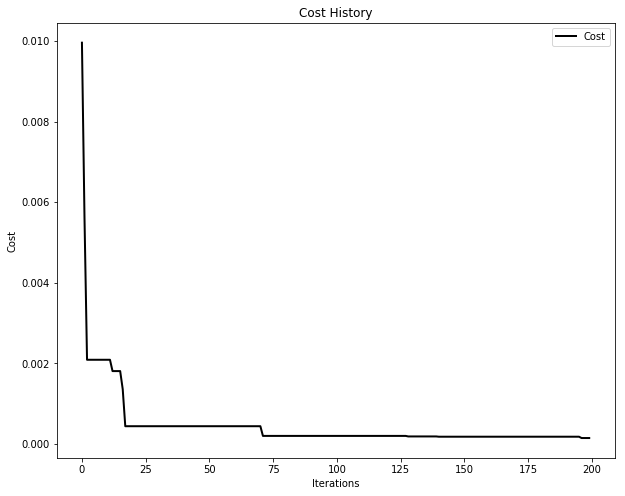

In [29]:
plot_cost_history(cost_history=optimizer.cost_history)
plt.show()

In [30]:
vmin, vmax = -20,0

PSO vs. TRUE, err 0.0001456601310588069


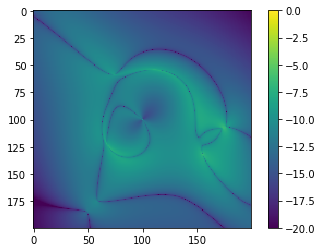

In [31]:
pso_img = args_to_img(pos)
print('PSO vs. TRUE, err', error(pso_img, image))
plt.imshow(np.log(abs(pso_img - image)), vmin=vmin, vmax=vmax); plt.colorbar(); plt.show()

NOSUB vs. TRUE
null error 0.02208777731029009


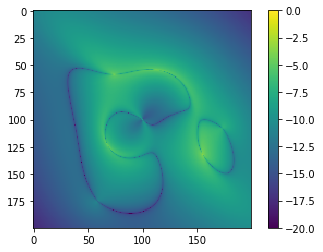

In [32]:
# no subhalos
print('NOSUB vs. TRUE')
nfw_idx = 2 if zl < zd else 1
nosub_args = ([image_obj.rsang, 0]+[image_obj.kwargs_lens[nfw_idx+i]['center_x'] for i in range(N)]
              +[image_obj.kwargs_lens[nfw_idx+i]['center_y'] for i in range(N)])
nosub_img = args_to_img(nosub_args)
print('null error', error(nosub_img, image))
plt.imshow(np.log(abs(nosub_img - image)), vmin=vmin, vmax=vmax); plt.colorbar(); plt.show()

NOSUB vs. PSO


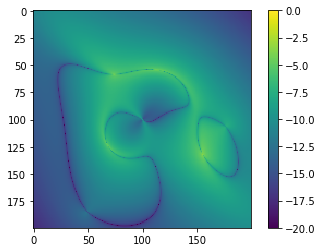

In [33]:
print('NOSUB vs. PSO')
plt.imshow(np.log(abs(nosub_img - pso_img)), vmin=vmin, vmax=vmax); plt.colorbar(); plt.show()

In [38]:
from helpers import inv_rs_angle, inv_alpha_s
import astropy.units as u

def get_mass_back(rsang, alphars):
    '''Starts with NFW rsang and alphars.
    Returns original NFW mass (out to R200?) in Msun.'''
    rs = inv_rs_angle(zd, rsang).to(u.Mpc).value
    mass = inv_alpha_s(alphars, rs, zd, zs).to(u.Msun)
    return mass.to(u.Msun).value

almost truth args [0.303784985137773, 6.952286183143494e-05, array(14.65880729), array(-8.25812715), array(1.56070615), array(14.94602379)]
almost truth error 6.073859049657506e-22


/home/arthur/Documents/cosmo/interlopers/venv/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


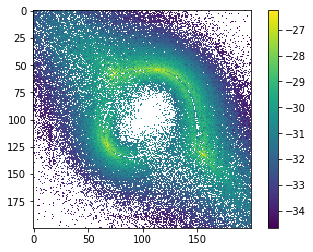

In [35]:
# "truth"-level (compared to truth image -- only really makes sense at zl \approx zd)
nfw_idx = 2 if zl < zd else 1 # index of first nfw lens (todo: check this)
almost_truth_args = ([image_obj.rsang, image_obj.alphars]
                     +[image_obj.kwargs_lens[nfw_idx+i]['center_x'] for i in range(N)]
                     +[image_obj.kwargs_lens[nfw_idx+i]['center_y'] for i in range(N)])
print('almost truth args', almost_truth_args)
almost_truth_img = args_to_img(almost_truth_args)
print('almost truth error', error(almost_truth_img, image))
plt.imshow(np.log(abs(almost_truth_img - image))); plt.colorbar(); plt.show()

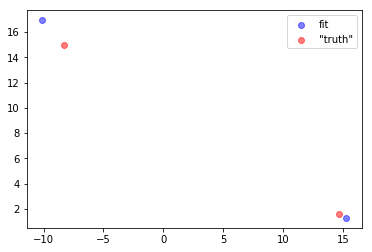

In [36]:
for idx in range(2,2+N):
    plt.scatter(pos[idx],pos[idx+N], color='blue', alpha=.5,
                label='fit' if idx==2 else None)
    plt.scatter(almost_truth_args[idx], almost_truth_args[idx+N], color='red', alpha=.5,
                label='"truth"' if idx==2 else None)
plt.legend()
plt.show()

So this first time I ran it on $z_d=z_l$, it got one of the two subhalo positions correct! I was later able to get both subhalo positions correct, but in any case, the masses were wrong.

In [37]:
print('pos: rsang', pos[0], 'alphars:', pos[1])
print('"truth": rsang', almost_truth_args[0], 'alphars:', almost_truth_args[1])

pos: rsang 0.30807209000696256 alphars: 7.533254739509722e-05
"truth": rsang 0.303784985137773 alphars: 6.952286183143494e-05


By the way, if we force the value of `rsang`, then `alphars` is pretty close: 7.95e-5, as opposed to truth 6.95e-5.

In [41]:
print('fit mass:', get_mass_back(pos[0], pos[1]) /1e6, 'million Msun')
print('"truth" mass:', get_mass_back(almost_truth_args[0], almost_truth_args[1]) /1e6,'million Msun')

fit mass: 11.143641010769084 million Msun
"truth" mass: 9.999999999999995 million Msun
